# Import Libraries

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
import cv2
import numpy as np

# Functions

In [2]:


def load_and_show_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # show our image
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    return image
    
def reshap_img(image):
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    return image

def find_clusters(image,clusters=3):
    clt = KMeans(n_clusters = clusters)
    clt.fit(image)
    return clt
    
def centroid_histogram(clt):
    
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster
    colors_data = []
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
        colors_data.append((percent,color))
    # return the bar chart
    return bar,colors_data

def plot_color_hist(clt):
    hist = centroid_histogram(clt)
    bar,colors_data = plot_colors(hist, clt.cluster_centers_)
    # show our color bart
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    return colors_data
    
def get_colors(path,clusters=2):
    image = load_and_show_img(path)
    image = reshap_img(image)
    clt = find_clusters(image,clusters=clusters)
    colors_data = plot_color_hist(clt)
    return colors_data
    
def get_rgb_list(df):
    rgb_list = []
    for i in range(len(df)):
        rgb_list.append(df.iloc[i][['R','G','B']].values)
    df['rgb'] = rgb_list
    return df
    
def get_colors_csv():
    path = "https://raw.githubusercontent.com/balajisrinivas/Color-Detection-OpenCV/main/colors.csv"
    index = ["color", "color_name", "hex", "R", "G", "B"]
    import pandas as pd
    df = pd.read_csv(path,names=index,header=None)    
    
    return df

def save_colors_csv():
    df = get_colors_csv()
    df.to_csv("../Dataset/archive/colors.csv")
    
def read_colors_csv(path="../Dataset/archive/colors.csv"):
    import pandas as pd
    df = pd.read_csv(path)
    df = df.iloc[:,1:]
    df = get_rgb_list(df)
    return df

    
def get_color_diffs(df,prod_color):
    diffs = []
    for i,rgb in enumerate(df['rgb']):
        d = np.sum(np.abs(prod_color-rgb))
        diffs.append((d,i))
    diffs.sort(key=lambda x: x[0],reverse=False)
    return diffs[0]

def predict_color(df,colors_data,num_cols=3):
    import numpy as np
    colors_data = remove_white(colors_data)
    for p,prod_color in colors_data[:num_cols]:
        color_data = get_color_diffs(df,prod_color)
        
        rgb,idx = color_data

        print("Color Name: {}".format(df.iloc[idx]['color']))
        print(df.iloc[idx]['rgb'])
        bar = np.zeros((50, 300, 3), dtype = "uint8")
        cv2.rectangle(bar, (0, 0), (300, 50),
                    df.iloc[idx]['rgb'].astype("uint8").tolist(), -1)
        plt.imshow(bar)
        plt.show()
    
def remove_white(colors_data):
    minIdx = 3
    m = 255*3
    white = [255.0,255.0,255.0]
    for i,(percent,color) in enumerate(colors_data):
        d = np.sum(np.abs(color-white))
        if d<m:
            m = d
            minIdx = i
    del colors_data[minIdx]
    colors_data.sort(key=lambda x: x[0],reverse=True)
    return colors_data

# Test

In [3]:
df = read_colors_csv()

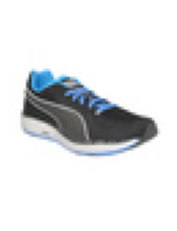

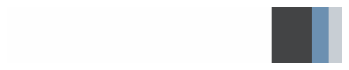

[(0.7922916666666666, array([254.63081778, 254.68077833, 254.65422035])), (0.120625, array([67.92227979, 68.33160622, 69.11744387])), (0.04895833333333333, array([108.12765957, 144.84255319, 177.43404255])), (0.038125, array([200.8579235 , 206.73224044, 212.69398907]))]


In [15]:
path = "../Dataset/archive/images/9198.jpg"
colors_data = get_colors(path,clusters=4)
print(colors_data)

Color Name: arsenic
[59 68 75]


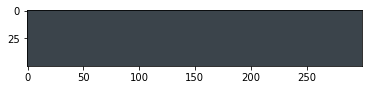

Color Name: cerulean_frost
[109 155 195]


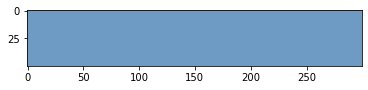

Color Name: light_gray
[211 211 211]


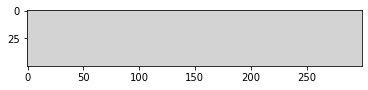

In [16]:
predict_color(df,colors_data.copy())